# Assignment 2: IR

## Preparations
* Put all your imports, and path constants in the next cells
* Make sure all your path constants are **relative to** ***DATA_DIR*** and **NOT hard-coded** in your code.

In [ ]:
!pip install whoosh
!pip install pytrec_eval
!pip install wget

In [ ]:
import wget
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/government.zip", "government.zip")

'government (1).zip'

In [ ]:
!unzip government.zip

In [ ]:
# imports
# Put all your imports here
from whoosh import index, writing
from whoosh.fields import Schema, TEXT, KEYWORD, ID, STORED
from whoosh.analysis import *
from whoosh.qparser import *
import os.path
from pathlib import Path
import tempfile
import subprocess
import pytrec_eval
import wget
import nltk
from nltk.stem import *
nltk.download("wordnet")
lrStem = LancasterStemmer()
sbStem = SnowballStemmer("english")
wnLemm = WordNetLemmatizer()
from whoosh import scoring


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
DATA_DIR = "government"
DOCUMENTS_DIR = os.path.join(DATA_DIR, "documents")
TOPIC_FILE = os.path.join(DATA_DIR, "gov.topics")
QRELS_FILE = os.path.join(DATA_DIR, "gov.qrels")


## Question 1
Provide your text answers in the following two markdown cells

### Q1 (a): Provide answer to Q1 (a) here [markdown cell]

Mean average precision (map) should be the proper measure. 


### Q1 (b): Provide answer to Q1 (b) here [markdown cell]

MAP is important since it measures the overall information retrieval precision on a certain topic/all the topics,which gives a straightforward evaluation of the accuracy of the search system.

## Question 2

### Q2 (a): Write your code below

In [ ]:
# Put your code for creating the index here (you can add more cells).
# Make sure you save the final index in the variable INDEX_Q2, your query parser in QP_Q2, and your searcher in SEARCHER_Q2

In [ ]:
def createIndex(schema):
    # Generate a temporary directory for the index
    indexDir = tempfile.mkdtemp()

    # create and return the index
    return index.create_in(indexDir, schema)
# first, define a Schema for the index
mySchema = Schema(file_path = ID(stored=True),
                  file_content = TEXT(analyzer = RegexTokenizer()))

# now, create the index at the path INDEX_DIR based on the new schema
myIndex = createIndex(mySchema)

In [ ]:
def addFilesToIndex(indexObj, fileList):
    # open writer
    writer = writing.BufferedWriter(indexObj, period=None, limit=1000)

    try:
        # write each file to index
        for docNum, filePath in enumerate(fileList):
            with open(filePath, "r", encoding="utf-8") as f:
                fileContent = f.read()
                writer.add_document(file_path = filePath,
                                    file_content = fileContent)

                # print status every 1000 documents
                if (docNum+1) % 1000 == 0:
                    print("already indexed:", docNum+1)
        print("done indexing.")

    finally:
        # close the index
        writer.close()

filesToIndex = [str(filePath) for filePath in Path(DOCUMENTS_DIR).glob("**/*") if filePath.is_file()]
addFilesToIndex(myIndex, filesToIndex) #add the pre-defined index to the list of files 

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [ ]:
# define a query parser for the field "file_content" in the index
myQueryParser = QueryParser("file_content", schema=myIndex.schema)
mySearcher = myIndex.searcher()


In [ ]:
def pyTrecEval(topicFile, qrelsFile, queryParser, searcher):
    # Load topic file - a list of topics(search phrases) used for evalutation
    with open(topicFile, "r") as tf:
        topics = tf.read().splitlines()

    # create an output file to which we'll write our results
    tempOutputFile = tempfile.mkstemp()[1]
    with open(tempOutputFile, "w") as outputTRECFile:
        # for each evaluated topic:
        # build a query and record the results in the file in TREC_EVAL format
        for topic in topics:
            topic_id, topic_phrase = tuple(topic.split(" ", 1))
            #print(topic_id, topic_phrase)
            topicQuery = queryParser.parse(topic_phrase)
            topicResults = searcher.search(topicQuery, limit=None)
            for (docnum, result) in enumerate(topicResults):
                score = topicResults.score(docnum)
                #print("%s Q0 %s %d %lf test\n" % (topic_id, os.path.basename(result["file_path"]), docnum, score))
                outputTRECFile.write("%s Q0 %s %d %lf test\n" % (topic_id, os.path.basename(result["file_path"]), docnum, score))
    with open(qrelsFile, 'r') as f_qrel:
        qrel = pytrec_eval.parse_qrel(f_qrel)

    with open(tempOutputFile, 'r') as f_run:
        run = pytrec_eval.parse_run(f_run)

    evaluator = pytrec_eval.RelevanceEvaluator(
        qrel, pytrec_eval.supported_measures)

    results = evaluator.evaluate(run)
    def print_line(measure, scope, value):
        print('{:25s}{:8s}{:.4f}'.format(measure, scope, value))

    for query_id, query_measures in results.items():
        for measure, value in query_measures.items():
            if measure == "runid":
              continue
            print_line(measure, query_id, value)
    for measure in query_measures.keys():
        if measure == "runid":
              continue
        print_line(
            measure,
            'all',
            pytrec_eval.compute_aggregated_measure(
                measure,
                [query_measures[measure]
                 for query_measures in results.values()]))

In [ ]:
pyTrecEval(TOPIC_FILE, QRELS_FILE, myQueryParser, mySearcher) 

num_q                    1       1.0000
num_ret                  1       1.0000
num_rel                  1       5.0000
num_rel_ret              1       0.0000
map                      1       0.0000
gm_map                   1       -11.5129
Rprec                    1       0.0000
bpref                    1       0.0000
recip_rank               1       0.0000
iprec_at_recall_0.00     1       0.0000
iprec_at_recall_0.10     1       0.0000
iprec_at_recall_0.20     1       0.0000
iprec_at_recall_0.30     1       0.0000
iprec_at_recall_0.40     1       0.0000
iprec_at_recall_0.50     1       0.0000
iprec_at_recall_0.60     1       0.0000
iprec_at_recall_0.70     1       0.0000
iprec_at_recall_0.80     1       0.0000
iprec_at_recall_0.90     1       0.0000
iprec_at_recall_1.00     1       0.0000
P_5                      1       0.0000
P_10                     1       0.0000
P_15                     1       0.0000
P_20                     1       0.0000
P_30                     1       0.000

In [ ]:
INDEX_Q2 = myIndex # Replace None with your index for Q2
QP_Q2 = myQueryParser # Replace None with your query parser for Q2
SEARCHER_Q2 = mySearcher # Replace None with your searcher for Q2
print(len(filesToIndex))

4078


### Q2 (b): Provide answer to Q2 (b) here [markdown cell]

The baseline Whoosh system achieved a score of 0.1917 on the mean average precision (MAP) for all topics in the list.It is not a good performance(19.17% of accuracy) for 4078 files.

map                      all     0.1971

### Q2 (c): Provide answer to Q2(c) here [markdown cell]

The search did not return any desired results for topic 1, 2,6,7,9,16 and 28, but found all the relavant files for topic 18 and 24. 

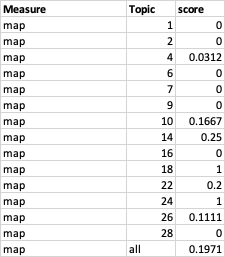

In [ ]:
def printRelName(topicFile, qrelsFile, queryParser, searcher, id):
  with open(topicFile, "r") as tf:
        topics = tf.read().splitlines()
  for topic in topics:
        topic_id, topic_phrase = tuple(topic.split(" ", 1))
        if topic_id == id:
          print("---------------------------Topic_id and Topic_phrase----------------------------------")
          print(topic_id, topic_phrase)
          topicQuery = queryParser.parse(topic_phrase)
          topicResults = searcher.search(topicQuery, limit=None)
          print("---------------------------Return documents----------------------------------")
          for (docnum, result) in enumerate(topicResults):
              score = topicResults.score(docnum)
              print("%s Q0 %s %d %lf test" % (topic_id, os.path.basename(result["file_path"]), docnum, score))
          print("---------------------------Relevant documents----------------------------------")
          with open(qrelsFile, 'r') as f_qrel:
            qrels = f_qrel.readlines()
            for i in qrels:
              qid, _, doc, rel = i.rstrip().split(" ")
              if qid == id and rel == "1":
                print(i.rstrip())
        

## Question 3

### Q3 (a): Provide answer to Q3 (a) here [markdown cell]

In [ ]:
printRelName(TOPIC_FILE, QRELS_FILE, myQueryParser, mySearcher,"4") 

---------------------------Topic_id and Topic_phrase----------------------------------
4 wireless communications
---------------------------Return documents----------------------------------
4 Q0 G00-99-2247765 0 16.449155 test
4 Q0 G00-85-1525415 1 13.364613 test
4 Q0 G00-05-1218739 2 12.956314 test
4 Q0 G00-09-0774298 3 11.781349 test
4 Q0 G00-56-4151981 4 11.367248 test
4 Q0 G00-21-2229498 5 10.743958 test
4 Q0 G00-98-4068688 6 10.464865 test
4 Q0 G00-47-2117970 7 10.213356 test
4 Q0 G00-67-0152545 8 8.392871 test
4 Q0 G00-06-1757034 9 6.431556 test
4 Q0 G00-78-2551063 10 3.955775 test
4 Q0 G00-84-0274223 11 2.068438 test
---------------------------Relevant documents----------------------------------
4 0 G00-03-2855342 1
4 0 G00-36-1275993 1
4 0 G00-47-2117970 1
4 0 G00-65-0162935 1


In [ ]:
tokenizer = RegexTokenizer()
#tokenizer = stmLwrStpIntraAnalyzer
[token.text for token in tokenizer("wireless telecommunications")]
#[token.text for token in tokenizer("The Wireless Telecommunications Bureau (WTB) handles nearly all FCCdomestic wireless telecommunications programs and policies. Wireless communications services include Amateur, Cellular, Paging, PCS, Public Safety, and more")]

['wireless', 'telecommunications']

We will look at the results for topic 4 - Wireless communications for example. Using the printrelname() function we can see that file G00-99-2247765 has the highest score, but was not marked as relevant on the qrel file (false positive). G00-36-12-75993 is a relevant file according to the qrel file, but it didn't even have a score (false negative).

One possible reason is that in the false-negative G00-36 file, the topic isn't directly referred, but is mentioned as "wireless telecommunications" and the searcher was unable to recognize this as a relevant information. The false-positive file G00-99, on the other hand, contains the exact word "wireless" and "communication", which fooled the searcher to consider it as relevant.

One way to improve this is to change the analyzer used in the schema so that it doesn't completely distinguish "telecommunication" from "communication".

### Q3 (b): Write your code below

In [ ]:
# Put your code for creating the index here (you can add more cells).
# Make sure you save the final index in the variable INDEX_Q3, your query parser in QP_Q3, and your searcher in SEARCHER_Q3

In [ ]:
stmLwrStpIntraAnalyzer = RegexTokenizer() | LowercaseFilter() | IntraWordFilter() | StopFilter() | StemFilter()
mySchema2 = Schema(file_path = ID(stored=True),
                   file_content = TEXT(analyzer = stmLwrStpIntraAnalyzer))

# create the index based on the new schema
myIndex2 = createIndex(mySchema2)
addFilesToIndex(myIndex2, filesToIndex)
myQueryParser2 = QueryParser("file_content", schema=myIndex2.schema)
mySearcher2 = myIndex2.searcher()
pyTrecEval(TOPIC_FILE, QRELS_FILE, myQueryParser2, mySearcher2) 

In [ ]:
INDEX_Q3 = myIndex2 # Replace None with your index for Q3
QP_Q3 = myQueryParser2 # Replace None with your query parser for Q3
SEARCHER_Q3 = mySearcher2 # Replace None with your searcher for Q3

### Q3 (c): Provide answer to Q3 (c) here [markdown cell]

In [ ]:
printRelName(TOPIC_FILE, QRELS_FILE, myQueryParser2, mySearcher2,"4") 

---------------------------Topic_id and Topic_phrase----------------------------------
4 wireless communications
---------------------------Return documents----------------------------------
4 Q0 G00-36-1275993 0 15.164268 test
4 Q0 G00-47-2117970 1 14.653076 test
4 Q0 G00-99-2247765 2 13.872368 test
4 Q0 G00-85-1525415 3 13.224219 test
4 Q0 G00-00-1958915 4 13.150225 test
4 Q0 G00-74-4030396 5 12.750312 test
4 Q0 G00-28-2286602 6 12.510099 test
4 Q0 G00-84-3349019 7 12.457022 test
4 Q0 G00-05-1218739 8 12.368941 test
4 Q0 G00-21-2229498 9 12.277661 test
4 Q0 G00-69-0005329 10 12.012922 test
4 Q0 G00-04-3812745 11 11.714154 test
4 Q0 G00-46-1439567 12 11.608975 test
4 Q0 G00-71-3454228 13 11.082992 test
4 Q0 G00-44-1482914 14 10.843163 test
4 Q0 G00-02-0735704 15 10.718063 test
4 Q0 G00-16-0059045 16 10.648743 test
4 Q0 G00-02-1720397 17 10.645318 test
4 Q0 G00-07-3064254 18 10.076573 test
4 Q0 G00-09-0774298 19 10.063448 test
4 Q0 G00-65-0162935 20 9.949202 test
4 Q0 G00-59-3586444 21

I modified the analyzer to use stemming, lower-case only, ignore prepositions and pronouns, and break connected words. 

The MAP for all topics increased to 0.3366, which is almost twice as what it was before (0.1917).

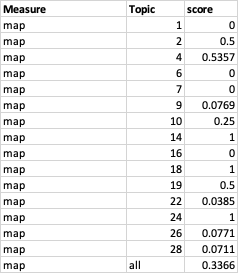

The performance of the false-positive and false-negative files mentioned in q2 also improved. The false-positive file G00-99-2247765 is now at third place with a score around 13, while the the false-negative file g00-36-1275993 turned out to have the highest score - 15.16. This is a huge progress considering it didn't even make to the result list with the previous RegexTokenizer().

### Q3 (d): Provide answer to Q3 (d) here [markdown cell]

Yes

### Q3 (e): Provide answer to Q3 (e) here [markdown cell]

Yes. Most of the topics performed better, but topic 22 and 26 achieved a lower MAP this time. 

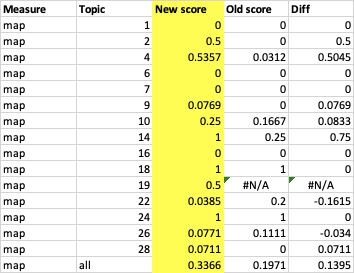

### Q3 (f): Provide answer to Q3 (f) here [markdown cell]

It means my changes were making good impact since the majority of the topics had a improvment on MAP, and it also increased the overall MAP by around 15%. It also returned reuslts for topic 19, which was completely skipped in the first iteration. 

## Question 4

In [ ]:
# Put your code for creating the index here (you can add more cells).
# Make sure you save the final index in the variable INDEX_Q4, your query parser in QP_Q4, and your searcher in SEARCHER_Q4

### Please answer the following questions here
(a) A clear list of all final modifications made.  
(b)  Why each modification was made – how did it help?  
(c)  The  final  MAP  performance  that  these  modifications  attained.

a) modification on BM25F scoring function parameters; 

adding a slope of 15 to the query parser in the pytrec_eval function; 

adding customized NLTK lemmatization filter to the analyzer and replaces the original stem filter with NLTK's LancasterStemmer filter.

b) The modification on BM25F function parameters is to find the best parameter for this dataset, and the addition of slope is to increase the distance allowed between words to allow for a fuzzy match. The adding of lemmatization filter help to convert the words to its meaningful base form, and I used the NLTK's LancasterStemmer filter since it provides better stemming than the original one.  All changes led to a increase in the MAP value. 

c) Final map performance:

**map                      all     0.4073**

In [ ]:
# Dont change this! Use it as-is in your code
# This filter will run for both the index and the query
from whoosh.analysis import Filter
class CustomFilter(Filter):
    is_morph = True
    def __init__(self, filterFunc, *args, **kwargs):
        self.customFilter = filterFunc
        self.args = args
        self.kwargs = kwargs
    def __eq__(self):
        return (other
                and self.__class__ is other.__class__)
    def __call__(self, tokens):
        for t in tokens:
            if t.mode == 'query': # if called by query parser
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t
            else: # == 'index' if called by indexer
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t

In [ ]:
def pyTrecEvalQ4(topicFile, qrelsFile, queryParser, searcher):
    # Load topic file - a list of topics(search phrases) used for evalutation
    with open(topicFile, "r") as tf:
        topics = tf.read().splitlines()

    # create an output file to which we'll write our results
    tempOutputFile = tempfile.mkstemp()[1]
    with open(tempOutputFile, "w") as outputTRECFile:
        # for each evaluated topic:
        # build a query and record the results in the file in TREC_EVAL format
        for topic in topics:
            topic_id, topic_phrase = tuple(topic.split(" ", 1))
            #print(topic_id, topic_phrase)
            topicQuery = queryParser.parse('"%s"~15' % topic_phrase)
            topicResults = searcher.search(topicQuery, limit=None)
            for (docnum, result) in enumerate(topicResults):
                score = topicResults.score(docnum)
                #print("%s Q0 %s %d %lf test\n" % (topic_id, os.path.basename(result["file_path"]), docnum, score))
                outputTRECFile.write("%s Q0 %s %d %lf test\n" % (topic_id, os.path.basename(result["file_path"]), docnum, score))
    with open(qrelsFile, 'r') as f_qrel:
        qrel = pytrec_eval.parse_qrel(f_qrel)

    with open(tempOutputFile, 'r') as f_run:
        run = pytrec_eval.parse_run(f_run)

    evaluator = pytrec_eval.RelevanceEvaluator(
        qrel, pytrec_eval.supported_measures)

    results = evaluator.evaluate(run)
    def print_line(measure, scope, value):
        print('{:25s}{:8s}{:.4f}'.format(measure, scope, value))

    for query_id, query_measures in results.items():
        for measure, value in query_measures.items():
            if measure == "runid":
              continue
            #print_line(measure, query_id, value)
    for measure in query_measures.keys():
        if measure == "runid":
              continue
        print_line(
            measure,
            'all',
            pytrec_eval.compute_aggregated_measure(
                measure,
                [query_measures[measure]
                 for query_measures in results.values()]))

In [288]:
myFilter1 =  CustomFilter(LancasterStemmer().stem)
myFilter2 =  CustomFilter(WordNetLemmatizer().lemmatize)
myFilter3 = CustomFilter(WordNetLemmatizer().lemmatize, 'v')
temp = RegexTokenizer() | LowercaseFilter() | IntraWordFilter() | StopFilter() | StemFilter()
stmLwrStpIntraAnalyzer = RegexTokenizer() | LowercaseFilter() | IntraWordFilter() | StopFilter() | myFilter3 | myFilter1


In [279]:
mySchematemp = Schema(file_path = ID(stored=True),
                   file_content = TEXT(analyzer = temp))

# create the index based on the new schema
myIndextemp = createIndex(mySchematemp)
addFilesToIndex(myIndextemp, filesToIndex)

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [280]:
myQueryParsertemp = QueryParser("file_content", schema=myIndextemp.schema)
mySearchertemp = myIndextemp.searcher()
pyTrecEvalQ4(TOPIC_FILE, QRELS_FILE, myQueryParsertemp, mySearchertemp) 

num_q                    all     12.0000
num_ret                  all     248.0000
num_rel                  all     21.0000
num_rel_ret              all     12.0000
map                      all     0.3882
gm_map                   all     0.0490
Rprec                    all     0.3333
bpref                    all     0.3333
recip_rank               all     0.4820
iprec_at_recall_0.00     all     0.4820
iprec_at_recall_0.10     all     0.4820
iprec_at_recall_0.20     all     0.4820
iprec_at_recall_0.30     all     0.4820
iprec_at_recall_0.40     all     0.4742
iprec_at_recall_0.50     all     0.4742
iprec_at_recall_0.60     all     0.3012
iprec_at_recall_0.70     all     0.3012
iprec_at_recall_0.80     all     0.2950
iprec_at_recall_0.90     all     0.2950
iprec_at_recall_1.00     all     0.2950
P_5                      all     0.1333
P_10                     all     0.0750
P_15                     all     0.0556
P_20                     all     0.0417
P_30                     all     0.

In [289]:
mySchema3 = Schema(file_path = ID(stored=True),
                   file_content = TEXT(analyzer = stmLwrStpIntraAnalyzer))

# create the index based on the new schema
myIndex3 = createIndex(mySchema3)
addFilesToIndex(myIndex3, filesToIndex)



already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [290]:
myQueryParser3 = QueryParser("file_content", schema=myIndex3.schema)
w = scoring.BM25F(B=0.52,K1=1.8)
mySearcher3 = myIndex3.searcher(weighting=w)

In [291]:
pyTrecEvalQ4(TOPIC_FILE, QRELS_FILE, myQueryParser3, mySearcher3) 

num_q                    all     12.0000
num_ret                  all     254.0000
num_rel                  all     21.0000
num_rel_ret              all     12.0000
map                      all     0.4073
gm_map                   all     0.0561
Rprec                    all     0.3333
bpref                    all     0.3333
recip_rank               all     0.5048
iprec_at_recall_0.00     all     0.5048
iprec_at_recall_0.10     all     0.5048
iprec_at_recall_0.20     all     0.5048
iprec_at_recall_0.30     all     0.5048
iprec_at_recall_0.40     all     0.4993
iprec_at_recall_0.50     all     0.4993
iprec_at_recall_0.60     all     0.3159
iprec_at_recall_0.70     all     0.3159
iprec_at_recall_0.80     all     0.3095
iprec_at_recall_0.90     all     0.3095
iprec_at_recall_1.00     all     0.3095
P_5                      all     0.1500
P_10                     all     0.0833
P_15                     all     0.0556
P_20                     all     0.0417
P_30                     all     0.

In [277]:
INDEX_Q4 = myIndex3 # Replace None with your index for Q4
QP_Q4 = myQueryParser3 # Replace None with your query parser for Q4
SEARCHER_Q4 = mySearcher3 # Replace None with your searcher for Q4

## Validation

In [ ]:
# Run the following cells to make sure your code returns the correct value types

In [ ]:
from whoosh.index import FileIndex
from whoosh.qparser import QueryParser
from whoosh.searching import Searcher
import os.path

### Q2 Validation

In [281]:
assert(isinstance(INDEX_Q2, FileIndex)), "Index Type"
assert(isinstance(QP_Q2, QueryParser)), "Query Parser Type"
assert(isinstance(SEARCHER_Q2, Searcher)), "Searcher Type"
print("Q2 Types Validated")

Q2 Types Validated


### Q3 Validation

In [283]:
assert(isinstance(INDEX_Q3, FileIndex)), "Index Type"
assert(isinstance(QP_Q3, QueryParser)), "Query Parser Type"
assert(isinstance(SEARCHER_Q3, Searcher)), "Searcher Type"
print("Q3 Types Validated")

Q3 Types Validated


### Q4 Validation

In [282]:
assert(isinstance(INDEX_Q4, FileIndex)), "Index Type"
assert(isinstance(QP_Q4, QueryParser)), "Query Parser Type"
assert(isinstance(SEARCHER_Q4, Searcher)), "Searcher Type"
print("Q4 Types Validated")

Q4 Types Validated
